In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [9]:


file_path= 'kaggle_Interests_group/kaggle_Interests_group.csv'
data = pd.read_csv(file_path)
# Display the first few rows of the dataset to understand its structure
data.head(), data.info()

# Filling NaN values with 0 in interest columns
data_filled = data.fillna(0)

# Encoding the 'group' column
label_encoder = LabelEncoder()
data_filled['group'] = label_encoder.fit_transform(data_filled['group'])

# Split the data into training and test sets
X_train, X_test = train_test_split(data_filled, test_size=0.2)
data_filled.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6340 entries, 0 to 6339
Columns: 219 entries, group to interest217
dtypes: float64(217), int64(1), object(1)
memory usage: 10.6+ MB


,group,grand_tot_interests,interest1,interest2,interest3,interest4,interest5,interest6,interest7,interest8,...,interest208,interest209,interest210,interest211,interest212,interest213,interest214,interest215,interest216,interest217
0,0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,43,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0,36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


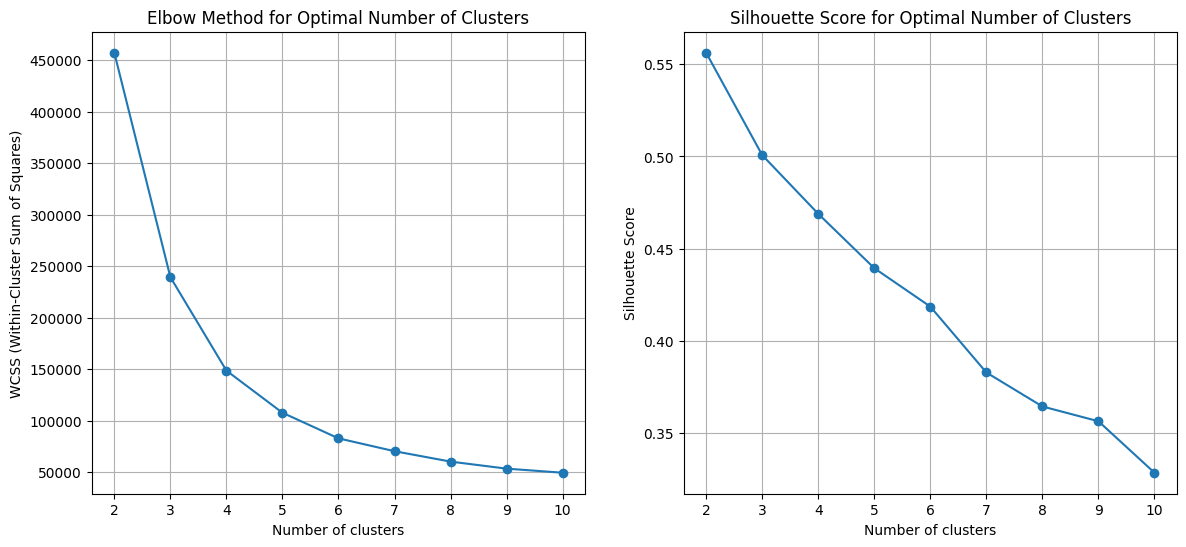

In [4]:

# Reduce dimensions to 10 using PCA for clustering
# https://www.kaggle.com/code/ankandash/pca-k-means-clustering-hierarchical-clustering
pca_10 = PCA(n_components=10)
pca_result_10_train = pca_10.fit_transform(X_train)


# Determining the optimal number of clusters using the Elbow method and Silhouette Score
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
Score = []
sil_scores = []
for i in range(2, 11):  # Starting from 2 as silhouette score is undefined for 1 cluster
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++')
    kmeans.fit(pca_result_10_train)
    Score.append(kmeans.inertia_)
    sil_score = silhouette_score(pca_result_10_train, kmeans.labels_)
    sil_scores.append(sil_score)


# Ploting the Elbow method graph and Silhouette scores
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), Score, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.show()


Silhouette Score for K-means clustering on PCA-reduced training data: 0.4184891089875287


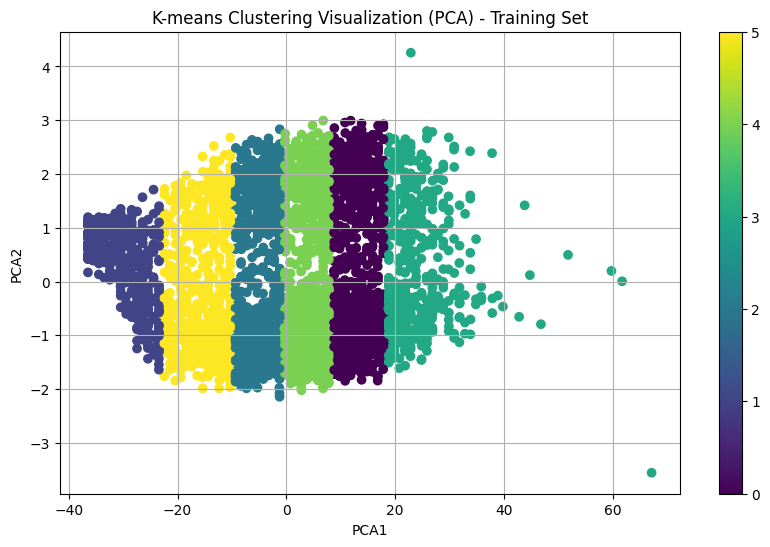

In [5]:

# Apply K-means clustering with the optimal number of clusters
optimal_clusters = 6  # Adjust based on Elbow and Silhouette Score
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, init='k-means++')
clusters_pca_10_train = kmeans.fit_predict(pca_result_10_train)

# Calculate the silhouette score for the PCA-reduced data
SScorePCATrain = silhouette_score(pca_result_10_train, clusters_pca_10_train)
print(f'Silhouette Score for K-means clustering on PCA-reduced training data: {SScorePCATrain}')
# Reduce dimensions to 2 using PCA for visualization
pca_2 = PCA(n_components=2)
pca_result_2_train = pca_2.fit_transform(pca_result_10_train)

# Create a DataFrame with the PCA results and cluster labels
pca_df_train = pd.DataFrame(pca_result_2_train, columns=['PCA1', 'PCA2'])
pca_df_train['cluster'] = clusters_pca_10_train

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_df_train['PCA1'], pca_df_train['PCA2'], c=pca_df_train['cluster'], cmap='viridis', marker='o')
plt.title('K-means Clustering Visualization (PCA) - Training Set')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar()
plt.grid(True)
plt.show()

In [6]:
# Fine-tune DBSCAN parameters
best_eps = 0.5
best_min_samples = 5
best_silhouette = -1

DBSCANEPSvalues = np.arange(0.1, 1.1, 0.1)
min_samples_values = range(3, 11)

for eps in DBSCANEPSvalues:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(pca_result_10_train)
        if len(set(labels)) > 1:  # More than 1 cluster
            sil_score = silhouette_score(pca_result_10_train, labels)
            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_eps = eps
                best_min_samples = min_samples

print(f'Best epsilon: {best_eps}')
print(f'Best min_samples: {best_min_samples}')
print(f'Best silhouette score on train data: {best_silhouette}')


Best epsilon: 0.5
Best min_samples: 9
Best silhouette score on train data: 0.42203735409656


Silhouette Score for DBSCAN clustering on PCA-reduced training data: 0.42203735409656


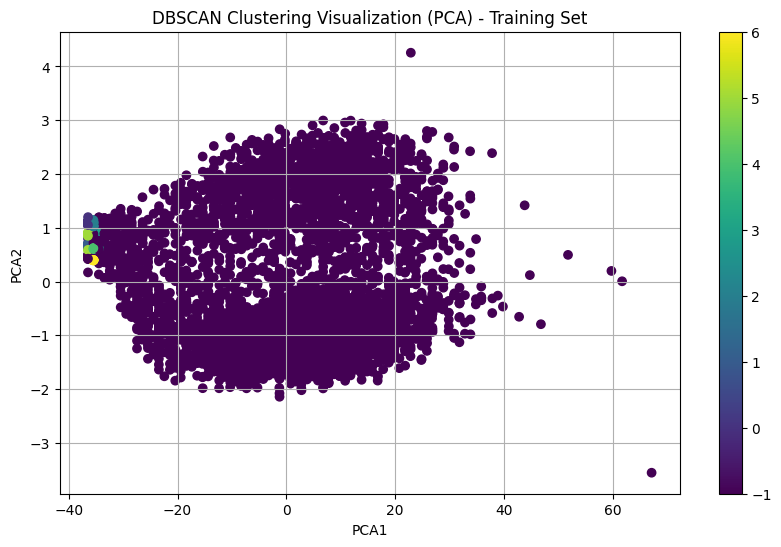

In [7]:
# Apply DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels_train = dbscan.fit_predict(pca_result_10_train)

# Add the DBSCAN cluster labels to the dataframe
pca_df_train['dbscan_cluster'] = dbscan_labels_train

# Calculate the silhouette score for the DBSCAN clustering
SScoreDBTrain = silhouette_score(pca_result_10_train, dbscan_labels_train)
print(f'Silhouette Score for DBSCAN clustering on PCA-reduced training data: {SScoreDBTrain}')

PCADBSCANTrain = pd.DataFrame(pca_result_2_train, columns=['PCA1', 'PCA2'])
PCADBSCANTrain['cluster'] = dbscan_labels_train

# Plot the DBSCAN clusters
plt.figure(figsize=(10, 6))
plt.scatter(PCADBSCANTrain['PCA1'], PCADBSCANTrain['PCA2'], c=PCADBSCANTrain['cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering Visualization (PCA) - Training Set')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar()
plt.grid(True)
plt.show()

Silhouette Score for K-means clustering on test set: 0.4009797508064607


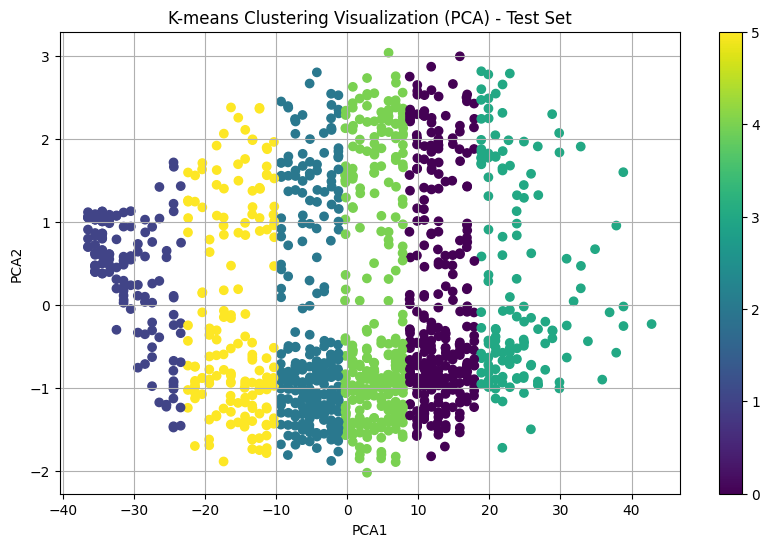

In [8]:

# Transform the test data using the same PCA model used for the training data
pca_result_10_test = pca_10.transform(X_test)

# Predict the clusters for the test data using the trained KMeans model
clusters_test = kmeans.predict(pca_result_10_test)

# Calculate the silhouette score for the test set
sil_score_test = silhouette_score(pca_result_10_test, clusters_test)
print(f'Silhouette Score for K-means clustering on test set: {sil_score_test}')
# Reducing dimesionality to 2 for visualisation
pca_result_2_test = pca_2.transform(pca_result_10_test)

# Create a DataFrame with the PCA results and cluster labels
pca_df_test = pd.DataFrame(pca_result_2_test, columns=['PCA1', 'PCA2'])
pca_df_test['cluster'] = clusters_test

# Plot the clusters for the test set
plt.figure(figsize=(10, 6))
plt.scatter(pca_df_test['PCA1'], pca_df_test['PCA2'], c=pca_df_test['cluster'], cmap='viridis', marker='o')
plt.title('K-means Clustering Visualization (PCA) - Test Set')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar()
plt.grid(True)
plt.show()
